# Batting average timeseries
> This notebook fetches game by game batting stats for each Dodgers player. 

In [14]:
import requests
import pandas as pd
from bs4 import BeautifulSoup, Comment
from io import StringIO
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = None

In [ ]:
TEAM_URL = "https://www.baseball-reference.com/teams/LAD/2025.shtml"
BASE_URL = "https://www.baseball-reference.com"

# Step 1: get player names and URLs
resp = requests.get(TEAM_URL)
soup = BeautifulSoup(resp.content, "html.parser")

# Check if table is in a comment block
table = soup.find("table", id="players_standard_batting")
if table is None:
    for c in soup.find_all(string=lambda text: isinstance(text, Comment)):
        if 'id="players_standard_batting"' in c:
            table = BeautifulSoup(c, "html.parser").find("table", id="players_standard_batting")
            break

if table is None:
    raise ValueError("Could not find the standard batting table.")

# Build name → url dictionary
player_dict = {
    a.text.strip(): BASE_URL + a["href"]
    for a in table.select("td[data-stat='name_display'] a")
}

# Step 2: loop through players and get gamelogs
frames = []

for name, player_url in tqdm(player_dict.items()):
    player_id = player_url.split('/')[-1].replace('.shtml', '')
    gamelog_url = f"https://www.baseball-reference.com/players/gl.fcgi?id={player_id}&t=b&year=2025"
    resp = requests.get(gamelog_url)
    soup = BeautifulSoup(resp.content, "html.parser")

    # Find the game log table
    table = soup.find("table", id="players_standard_batting")
    if table is None:
        for c in soup.find_all(string=lambda text: isinstance(text, Comment)):
            if "players_standard_batting" in c:
                table = BeautifulSoup(c, "html.parser").find("table", id="players_standard_batting")
                if table:
                    break

    if table is None:
        print(f"⚠️ Could not find table for {name} ({player_id})")
        continue

    df = pd.read_html(StringIO(str(table)))[0]
    df = df[df["Rk"] != "Rk"].copy()  # Remove repeated header rows
    df["player_name"] = name
    df["player_id"] = player_id
    df.reset_index(drop=True, inplace=True)
    frames.append(df)

    time.sleep(5)

In [27]:
players_to_keep = ['Will Smith', 'Freddie Freeman', 'Tommy Edman', 'Mookie Betts',
       'Max Muncy', 'Michael Conforto', 'Andy Pages', 'Teoscar Hernández',
       'Shohei Ohtani', 'Kiké Hernández', 'Miguel Rojas', 'Hyeseong Kim',
       'Dalton Rushing']

In [29]:
# Combine all players' logs
combined_df = pd.concat(frames, ignore_index=True).query('Pos != "P"').dropna()
combined_df.columns = combined_df.columns.str.lower()

In [32]:
batting_df = combined_df.query(f'player_name.isin({players_to_keep})').copy()

In [48]:
batting_slim = batting_df[['date', 'player_name', 'ba']].copy()
# Ensure correct types
batting_slim["ba"] = pd.to_numeric(batting_slim["ba"], errors="coerce")
batting_slim["date"] = pd.to_datetime(batting_slim["date"])

smith = batting_slim.query('player_name == "Will Smith"').copy()
ohtani = batting_slim.query('player_name == "Shohei Ohtani"').copy()

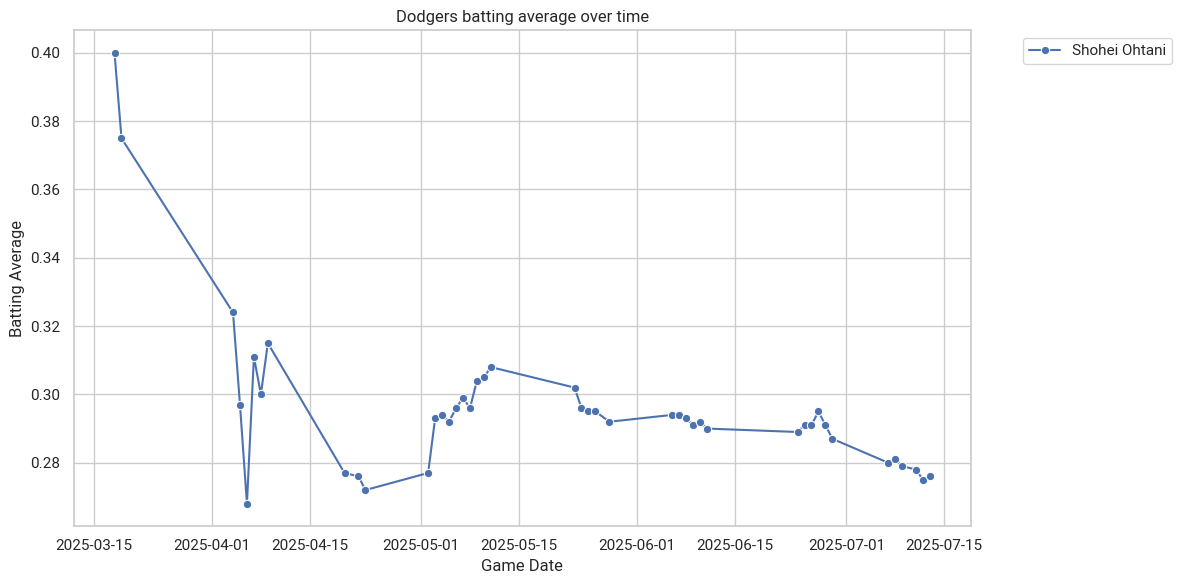

In [50]:
# Set up plot style
sns.set(style="whitegrid", font="Roboto", rc={"figure.figsize": (12, 6)})

# Plot batting averages
plt.figure()
sns.lineplot(data=ohtani, x="date", y="ba", hue="player_name", marker="o")

# Cleanup
plt.title("Dodgers batting average over time")
plt.ylabel("Batting Average")
plt.xlabel("Game Date")
plt.legend(title="", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()